# Coincap_ETL_Time_Series

In this project am doing a simple ETL project:
    1.I am extracting data from coincap api
        the date am pulling is for bitcoin price
    2.clean the extracted data
        by ensuring we only have the necessary data for time series
    3.load the data into postgres database for analysis
        
From here I scheduled the project to run with cron scheduler and also used python for pulling the data.

## Extract data from Coincap api

In [1]:
import requests
import json
import csv
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine
from time import time

In [2]:
url = "http://api.coincap.io/v2/assets/bitcoin/history?interval=d1"

payload={}
headers = {}

response = requests.request("GET", url, headers=headers, data=payload)

json_data = json.loads(response.text.encode('utf8'))

## Transform the data

In [3]:
bitcoin_df = json_data['data']
print(bitcoin_df)

[{'priceUsd': '40266.2985624923021089', 'time': 1647388800000, 'date': '2022-03-16T00:00:00.000Z'}, {'priceUsd': '40932.3748789127609498', 'time': 1647475200000, 'date': '2022-03-17T00:00:00.000Z'}, {'priceUsd': '40979.2815547523839302', 'time': 1647561600000, 'date': '2022-03-18T00:00:00.000Z'}, {'priceUsd': '41881.1811644147612857', 'time': 1647648000000, 'date': '2022-03-19T00:00:00.000Z'}, {'priceUsd': '41686.2911602767510070', 'time': 1647734400000, 'date': '2022-03-20T00:00:00.000Z'}, {'priceUsd': '41152.3439857619431726', 'time': 1647820800000, 'date': '2022-03-21T00:00:00.000Z'}, {'priceUsd': '42479.1514419936323156', 'time': 1647907200000, 'date': '2022-03-22T00:00:00.000Z'}, {'priceUsd': '42288.3437914861131093', 'time': 1647993600000, 'date': '2022-03-23T00:00:00.000Z'}, {'priceUsd': '43248.4745282626486354', 'time': 1648080000000, 'date': '2022-03-24T00:00:00.000Z'}, {'priceUsd': '44325.7281396889698303', 'time': 1648166400000, 'date': '2022-03-25T00:00:00.000Z'}, {'priceUs

In [4]:
df = pd.DataFrame(bitcoin_df)
df.to_csv('bitcoin_usd.csv',index=False)

In [5]:
print(df.head(10))

                 priceUsd           time                      date
0  40266.2985624923021089  1647388800000  2022-03-16T00:00:00.000Z
1  40932.3748789127609498  1647475200000  2022-03-17T00:00:00.000Z
2  40979.2815547523839302  1647561600000  2022-03-18T00:00:00.000Z
3  41881.1811644147612857  1647648000000  2022-03-19T00:00:00.000Z
4  41686.2911602767510070  1647734400000  2022-03-20T00:00:00.000Z
5  41152.3439857619431726  1647820800000  2022-03-21T00:00:00.000Z
6  42479.1514419936323156  1647907200000  2022-03-22T00:00:00.000Z
7  42288.3437914861131093  1647993600000  2022-03-23T00:00:00.000Z
8  43248.4745282626486354  1648080000000  2022-03-24T00:00:00.000Z
9  44325.7281396889698303  1648166400000  2022-03-25T00:00:00.000Z


In [6]:
df_cleaner = df.drop(['date'],axis=1)
df_cleaner.head()

,priceUsd,time
0,40266.2985624923021089,1647388800000
1,40932.3748789127609498,1647475200000
2,40979.2815547523839302,1647561600000
3,41881.1811644147612857,1647648000000
4,41686.2911602767510070,1647734400000


In [7]:
data = df_cleaner.astype({'priceUsd':'float'})

In [8]:
data.to_csv('bitcoin_data.csv',index=False)

## Bitcoin time series price

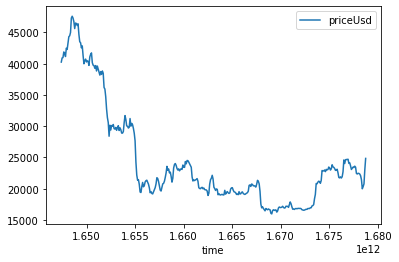

In [9]:
data.plot(x='time',y='priceUsd',kind='line')
plt.show()

## load data into postgres database

In [10]:
engine = create_engine("postgresql://{user}:{password}@{host}:{port}/{database}")
conn = engine.connect()

In [11]:
conn

In [12]:
df_iter = pd.read_csv('bitcoin_data.csv',iterator=True,chunksize=50)


In [13]:
try:
    while True:
        start_time = time()
        d = next(df_iter)
        d.to_sql(con=conn, name="bitcoin_data",index='False',if_exists="append")
        end_time = time()
        print("New records added {}".format(end_time-start_time))
except StopIteration:
    print("all records ingested")

New records added 0.08628988265991211
New records added 0.030466556549072266
New records added 0.023898601531982422
New records added 0.03543853759765625
New records added 0.025106430053710938
New records added 0.021282434463500977
New records added 0.013638496398925781
New records added 0.014513015747070312
all records ingested
